In [1]:
import database
from dataset import Dataset
from ae_test import AutoencoderTest
import torch.optim as optim
import torch
from tqdm import tqdm_notebook
import torch.nn.functional as F
import numpy as np
import os
# 如果想要import 子文件下的py檔，需要在子文件下建立一個__init__.py，可以爲空
import plt.plt_hist as plt_hist

In [2]:
dataset_name = 'bike_sharing'
pre_sort = 'sort/'+dataset_name+'_sort.pth'
batch_size = 64
batch = []
rows = 17379

In [3]:
# 資料庫連接設定
db = database.DEFAULT_DB()
db.setUp()

In [4]:
# 資料集資料載入
dataset = Dataset(db,dataset_name)
dataset.load(batch_size,1,1,all_level=True)
rawdata = dataset.rawdata
rawdata.shape

new dataset: bike_sharing


(17379, 14)

In [5]:
# 給定一個distance matric index，回傳計算這個distance的兩個instance的index
def find_index(index,rows):
    item1 = 0
    item2 =0
    rowstemp = rows-1
    for i in range(0,rows):
        slot = i + 1
        if(index < (rowstemp-i)):
            item1 = i
            item2 = index + slot 
            break
        index -= rowstemp-i
    return item1,item2

In [6]:
# 資料點兩兩之間距離矩陣
def distance(data, eps=1e-8):
    n = data.shape[0]
    distance_matrix = []
    data = data.to(data.device)
    for i in tqdm_notebook(range(n)):
        dist = data - data[i:i+1].repeat(n, 1)
        dist = dist.pow(2).sum(1)
        dist = (dist+eps).sqrt()
        dist[i] = 0
        distance_matrix.append(dist)
    distance_matrix = torch.cat(distance_matrix,0).view(n,n)
    distance_matrix = distance_matrix.cpu()
    mask = torch.ones(n,n)
    mask = torch.triu(mask,diagonal=1)
    mean = distance_matrix[mask>0].mean()
#     print("######:", mean)
    distance_matrix[mask>0] = distance_matrix[mask>0]/mean
    return distance_matrix[mask>0]

In [7]:
# 繪製出隨機挑選出的batch的hist
def draw_select(batch,k,file='pickBydistance'):
    batch_data = []
    for i in batch:
        batch_data.append(rawdata[i])
    batch_data = torch.Tensor(batch_data)
    batch_data.shape
    batch_map = distance(batch_data)
    plt_hist.draw_hist(data=batch_map,batch_size=batch_size,title='batch_hist'+str(k),file=file)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


151006131


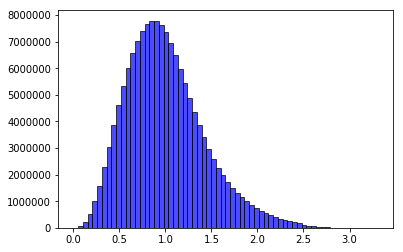

In [8]:
# 绘制distance_map分布直方图
# 利用torch.numpy()將torch array 轉換爲numpy array
distance_map = torch.load('distance_map/'+dataset_name+'_pre_compute_distance_matrix.pth').numpy()
plt_hist.draw_hist(data=distance_map,batch_size=64)
print(distance_map.shape[0])
total_length = distance_map.shape[0] 

In [9]:
print(distance_map.shape)
# 將distance matrix進行排序
if not os.path.exists(pre_sort):
    distance_map_sort = np.argsort(distance_map)
    torch.save(distance_map_sort,pre_sort)
else:
    distance_map_sort = torch.load(pre_sort)

(151006131,)


In [10]:
# 將距離矩陣分割爲 batch_size 的份數
separate_index = []
slot = int(total_length/(batch_size/2))
for i in range(0,int(batch_size/2)):
    separate_index.append(int(i*slot))
separate_index.append(int(total_length))
len(separate_index)

33

In [11]:
# 1.從dataloader中順序挑選出的batch_data
# 兩兩之間的 distance 分佈的 hist
# INPUT_DIM = len(dataset.columns)
# i = 0
# for batch_data in tqdm_notebook(dataset.dataloader):
#     batch_data = batch_data[:INPUT_DIM]
#     batch_data = torch.Tensor(batch_data)
#     batch_map = distance(batch_data)
#     plt_hist.draw_hist(data=batch_map,batch_size=batch_size,title='batch_hist'+str(i),file='org')
#     i += 1

In [12]:
# 2.將random得到的距離index還原回原始的資料index
# 並將其放入batch中
# k = 0
# for _ in tqdm_notebook(range(273)):
#     print(k)
#     random_index = []
#     batch = []
#     i = 0
#     for i in range(0,int(batch_size/2)):
#         item = np.random.randint(separate_index[i],separate_index[i+1],size=1)
#         random_index.append(item)
#     for i in range(0,int(batch_size/2)):
#         index = distance_map_sort[random_index[i][0]]
#         idx1,idx2 = find_index(index,rows)
#         batch.append(int(idx1))
#         batch.append(int(idx2))
#     batch = set(batch)
#     draw_select(batch,k)
#     k+=1

In [13]:
# 3.計算distance_map,將其對row取平均。
# data = torch.Tensor(rawdata)
# eps = 1e-8
# n = data.shape[0]
# distance_matrix = []
# data = data.to(data.device)
# for i in tqdm_notebook(range(n)):
#     dist = data - data[i:i+1].repeat(n, 1)
#     dist = dist.pow(2).sum(1)
#     dist = (dist+eps).sqrt()
#     dist[i] = 0
#     distance_matrix.append(dist)
# # 將data進行縱向排序，torch.cat(data,0).view(n,n)
# distance_matrix = torch.cat(distance_matrix,0).view(n,n)
# distance_matrix = distance_matrix.cpu()
# # 使用 torch.mean將每一個row求和，參數分別對應的是 data，dim，是否保持張量與輸入一致
# distance_matrix = torch.mean(distance_matrix, 1, True)
# distance_matrix = distance_matrix.numpy()


In [14]:
# 將算出的 distance_mean 切片
# 需要注意一個問題，通常而言在numpy中（2,1）指的並不是一位數組，我們需要將其攤平
# 這裏使用的是 numpy.flatten()
# distance_matrix=distance_matrix.flatten()
# total_length = distance_matrix.shape[0]
# distance_matrix_sort = np.argsort(distance_matrix)
# separate_index = []
# slot = int(total_length/batch_size)
# for i in range(0,int(batch_size)):
#     separate_index.append(int(i*slot))
# separate_index.append(int(total_length))

In [15]:
# 繪製圖像
# k = 0
# for _ in tqdm_notebook(range(273)):
#     print(k)
#     batch = []
#     i = 0
#     for i in range(0,int(batch_size)):
#         item = np.random.randint(separate_index[i],separate_index[i+1],size=1)
#         item = distance_matrix_sort[item[0]]
#         batch.append(item)
#     batch = set(batch)
#     draw_select(batch,k,'pickBymean')
#     k+=1